# テキストデータの可視化入門

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shinchu/dataviz-notebooks/blob/main/week_5/intro-to-visualizing-text-data.ipynb)

今回は、[青空文庫](https://www.aozora.gr.jp/)に収録されている、夏目漱石の[『三四郎』](https://www.aozora.gr.jp/cards/000148/card794.html)という作品を使って、テキストデータの可視化を練習します。

自然言語処理のフレームワークである[spaCy](https://spacy.io/)とこれを利用した日本語NLPライブラリである[GiNZA](https://megagonlabs.github.io/ginza/)を使います。

![](https://spacy.io/pipeline-fde48da9b43661abcdf62ab70a546d71.svg)

spaCyでは、各コンポーネント（機能）が順番に適用されるpipeline方式でテキストが処理されます。基本的には、tokenizer（分かち書き）、tagger（品詞付与）、parser（係り受け解析）、ner（固有表現抽出）、lemmatizer（原形抽出）、textcat（文書分類）というコンポーネントが用意されています。

`nlp()`を実行するとデフォルトでtokenizer、tagger、parser、ner、lemmatizerが入力文書に適用されます。

spaCyとGiNZAと比べて、より長く使われてきたライブラリとして、

* [NLTK (Natural Language Toolkit)](https://www.nltk.org/index.html)
* [MeCab](https://taku910.github.io/mecab/)（形態素解析） + [CaboCha](https://taku910.github.io/cabocha/)（係り受け解析）
* [JUMAN](https://nlp.ist.i.kyoto-u.ac.jp/?JUMAN)（形態素解析） + [KNP](https://nlp.ist.i.kyoto-u.ac.jp/?KNP)（係り受け解析）

などがあります。

より高度な分析をする時に必要となることがあるので、余力があったらチェックしてみてください。

それでは、spaCyを使った形態素解析の方法を確認してから、テキストデータの可視化を行いましょう。

## 形態素解析の練習

形態素解析は、文章を一つ一つの形態素に分ける技術です。形態素は、「言葉が意味を持つまとまりの単語の最小単位」です。

In [1]:
# ライブラリのインストール

!pip install spacy ginza ja-ginza
!pip install sklearn pandas


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


### 日本語

spaCyで日本語の形態素解析モデル（`ja_ginza`）をロードして、形態素解析をしてみましょう。

In [3]:
import spacy

nlp = spacy.load("ja_ginza")
text = "これは文章です。"
doc = nlp(text)
for token in doc:
    print(token)

これ
は
文章
です
。


形態素解析の結果には、語の原形や品詞の情報も含まれます。

In [59]:
text = "うとうととして目がさめると女はいつのまにか、隣のじいさんと話を始めている。このじいさんはたしかに前の前の駅から乗ったいなか者である。発車まぎわに頓狂な声を出して駆け込んで来て、いきなり肌をぬいだと思ったら背中にお灸のあとがいっぱいあったので、三四郎の記憶に残っている。じいさんが汗をふいて、肌を入れて、女の隣に腰をかけたまでよく注意して見ていたくらいである。"
doc = nlp(text)
for token in doc:
    print(f"{token}\t{token.lemma_}\t{token.pos_}\t{token.tag_}")

うとうと	うとうと	ADV	副詞
と	と	ADP	助詞-格助詞
し	する	VERB	動詞-非自立可能
て	て	SCONJ	助詞-接続助詞
目	目	NOUN	名詞-普通名詞-一般
が	が	ADP	助詞-格助詞
さめる	さめる	VERB	動詞-一般
と	と	ADP	助詞-格助詞
女	女	NOUN	名詞-普通名詞-一般
は	は	ADP	助詞-係助詞
いつ	いつ	PRON	代名詞
の	の	ADP	助詞-格助詞
ま	ま	NOUN	名詞-普通名詞-助数詞可能
に	に	ADP	助詞-格助詞
か	か	ADP	助詞-副助詞
、	、	PUNCT	補助記号-読点
隣	隣	NOUN	名詞-普通名詞-一般
の	の	ADP	助詞-格助詞
じい	じい	NOUN	名詞-普通名詞-一般
さん	さん	NOUN	接尾辞-名詞的-一般
と	と	ADP	助詞-格助詞
話	話	NOUN	名詞-普通名詞-サ変可能
を	を	ADP	助詞-格助詞
始め	始める	VERB	動詞-非自立可能
て	て	SCONJ	助詞-接続助詞
いる	いる	AUX	動詞-非自立可能
。	。	PUNCT	補助記号-句点
この	この	DET	連体詞
じい	じい	NOUN	名詞-普通名詞-一般
さん	さん	NOUN	接尾辞-名詞的-一般
は	は	ADP	助詞-係助詞
たしか	たしか	ADJ	形状詞-一般
に	だ	AUX	助動詞
前	前	NOUN	名詞-普通名詞-副詞可能
の	の	ADP	助詞-格助詞
前	前	NOUN	名詞-普通名詞-副詞可能
の	の	ADP	助詞-格助詞
駅	駅	NOUN	名詞-普通名詞-一般
から	から	ADP	助詞-格助詞
乗っ	乗る	VERB	動詞-一般
た	た	AUX	助動詞
いなか者	いなか者	NOUN	名詞-普通名詞-一般
で	だ	AUX	助動詞
ある	ある	AUX	動詞-非自立可能
。	。	PUNCT	補助記号-句点
発車	発車	NOUN	名詞-普通名詞-サ変可能
まぎわ	まぎわ	NOUN	名詞-普通名詞-一般
に	に	ADP	助詞-格助詞
頓狂	頓狂	ADJ	形状詞-一般
な	だ	AUX	助動詞
声	声	NOUN	名詞-普通名詞-一般
を	を	ADP	助詞-格助詞
出し	出す	VERB	動詞-非自立可能
て	て	SCONJ	助詞-接続助詞
駆け込ん	駆け込む	VERB	動詞-一般
で	で	SCONJ	助詞-接

### 英語

spaCyでは、モデルを変えるだけで同じ手順で他言語の解析を行うことができます。

英語のモデルでも試してみましょう。

In [5]:
# 英語のモデルをダウンロードする
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 8.6 MB/s eta 0:00:00m eta 0:00:010:01:01
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 2.3.1
    Uninstalling en-core-web-sm-2.3.1:
      Successfully uninstalled en-core-web-sm-2.3.1

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [7]:
nlp = spacy.load('en_core_web_sm')
text = "This is a sentence."
doc = nlp(text)
for token in doc:
    print(f"{token}\t{token.lemma_}\t{token.pos_}\t{token.tag_}")

This	this	PRON	DT
is	be	AUX	VBZ
a	a	DET	DT
sentence	sentence	NOUN	NN
.	.	PUNCT	.


## テキストデータの可視化

それでは、『三四郎』を題材にテキストデータの可視化を行ってみましょう。

* ワードクラウド
* 共起ネットワーク
* 共起マトリックス

の3種類を紹介します。

### データの用意

まずは、青空文庫からテキストデータをダウンロードします。解凍されたファイルの文字コードがShift-JISになっている点に注意しましょう。

In [8]:
# ファイルをダウンロードする
!wget https://www.aozora.gr.jp/cards/000148/files/794_ruby_4237.zip
# textフォルダ作る
!mkdir -p text
# ファイルをtextフォルダに解凍
!unzip -d text -o 794_ruby_4237.zip

--2022-11-10 02:16:38--  https://www.aozora.gr.jp/cards/000148/files/794_ruby_4237.zip
Resolving www.aozora.gr.jp (www.aozora.gr.jp)... 59.106.13.115
Connecting to www.aozora.gr.jp (www.aozora.gr.jp)|59.106.13.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 158711 (155K) [application/zip]
Saving to: ‘794_ruby_4237.zip.2’

794_ruby_4237.zip.2 100%[===================>] 154.99K  --.-KB/s    in 0.03s   

2022-11-10 02:16:38 (5.84 MB/s) - ‘794_ruby_4237.zip.2’ saved [158711/158711]

Archive:  794_ruby_4237.zip
  inflating: text/sanshiro.txt       


次に、正規表現で青空文庫のルビ、注、アクセントの記号を取り除きます。

同時に、文字コードをShift-JISからUTF-8にします。

```

-------------------------------------------------------
【テキスト中に現れる記号について】

《》：ルビ
（例）頓狂《とんきょう》

｜：ルビの付く文字列の始まりを特定する記号
（例）福岡県｜京都郡《みやこぐん》

［＃］：入力者注　主に外字の説明や、傍点の位置の指定
　　　（数字は、JIS X 0213の面区点番号またはUnicode、底本のページと行数）
（例）※［＃「魚＋師のつくり」、第4水準2-93-37］

〔〕：アクセント分解された欧文をかこむ
（例）〔ve'rite'《ヴェリテ》 vraie《ヴレイ》.〕
アクセント分解についての詳細は下記URLを参照してください
http://www.aozora.gr.jp/accent_separation.html
-------------------------------------------------------

```

In [9]:
import re

input_fn = "text/sanshiro.txt"
output_fn = "text/sanshiro.stripruby.txt"

with open(input_fn, encoding="shift_jis") as fin, open(output_fn, mode="w") as fout:
    for line in fin:
        fout.write(re.sub(r"《[^》]+》|［[^］]+］|〔[^〕]+〕| [｜]", "", line))

冒頭と末尾の説明を取り除きます（何行取り除くかは目視で確認）。

In [10]:
!tail -n +22 text/sanshiro.stripruby.txt | head -n -14 > text/sanshiro.corpus.txt

これで、テキストファイルを扱う準備ができました。

### ワードクラウド

ワードクラウドは、形態素解析で得られた頻出単語の頻出度合いを文字の大きさで可視化する手法です。頻度の高い単語を大きく表示することで、テキスト全体の傾向を素早く理解することができます。

#### 形態素解析

それでは、『三四郎』に出現する単語の頻度を数えてみましょう。

テキストファイルを読み込んで形態素解析を行います。

In [16]:
input_fn = "text/sanshiro.corpus.txt"
output_fn = "text/sanshiro.wakati.txt"

nlp = spacy.load("ja_ginza")

with open(input_fn, "r") as fin, open(output_fn, "w") as fout:
    for line in fin:
        tokens = [token.text for token in nlp(line.rstrip())]
        fout.write(' '.join(tokens) + "\n")

出力されたファイルを確認すると、分かち書きされていることが分かります。

次に、使用頻度の高い単語を見てみましょう。

In [46]:
from collections import Counter

# 分析対象とする品詞（内容語 - 名詞、動詞、形容詞）と不要語（ストップワード）を指定する
include_pos = ("NOUN", "VERB", "ADJ")

# ファイルを読み込み、テキストを一行ずつ解析
all_tokens = []
with open(input_fn, "r") as f:
    for line in f:
        tokens = [token for token in nlp(line)]
        all_tokens.extend(tokens)
        
# 単語の頻度を数える
counter = Counter(token.lemma_ for token in all_tokens if token.pos_ in include_pos and token.lemma_ not in stopwords)

# 出現頻度top 20を出力する
for word, count in counter.most_common(20):
    print(f"{count:>5} {word}")

  614 言う
  385 女
  373 さん
  328 見る
  318 来る
  314 先生
  297 出る
  262 聞く
  262 人
  259 時
  253 行く
  241 思う
  172 自分
  171 男
  168 みる
  161 事
  158 上
  158 気
  152 所
  150 お


#### ワードクラウドの作成

それでは、このデータをもとにワードクラウドを作成します。

In [18]:
# ライブラリをインストールする
!pip install wordcloud


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
# 日本語フォントのダウンロード
%%bash
sudo apt update
sudo apt install fonts-ipaexfont

In [29]:
import platform

if platform.system() == "Linux":
    fpath = "/usr/share/fonts/opentype/ipaexfont-gothic/ipaexg.ttf"
else:
    fpath = "/Users/shu/Library/Fonts/NotoSansJP-Regular.otf"

In [27]:
words = [token.lemma_ for token in all_tokens if token.pos_ in include_pos and token.lemma_ not in stopwords]

In [47]:
words

array(['affect', 'akin', 'amaranth', ..., '鼠色', '鼻筋', '鼻緒'], dtype=object)

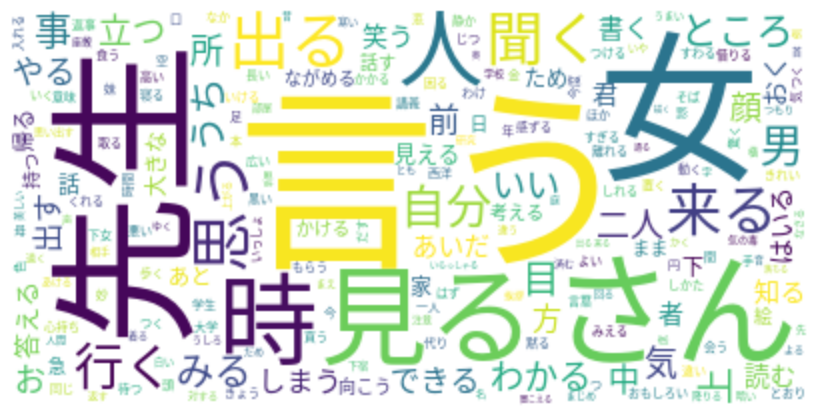

In [30]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# ワードクラウドの表示設定と作成
wordcloud = WordCloud(
    background_color="white", max_font_size=100, font_path=fpath
).generate(' '.join(words))

# プロット
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

「先生」、「言う」、「女」、「見る」などが高頻度で出現していることが分かります。

分析対象の品詞に、固有名詞を加えてみたらどうでしょうか？試してみましょう。

In [31]:
# 分析対象とする品詞と不要語を指定する
# your code goes in ????? below

include_pos = ("NOUN", "VERB", "ADJ", "?????")
stopwords = ("する", "ある", "ない", "いう", "もの", "こと", "よう", "なる", "ほう", "いる", "くる")

In [32]:
words = [token.lemma_ for token in all_tokens if token.pos_ in include_pos and token.lemma_ not in stopwords]

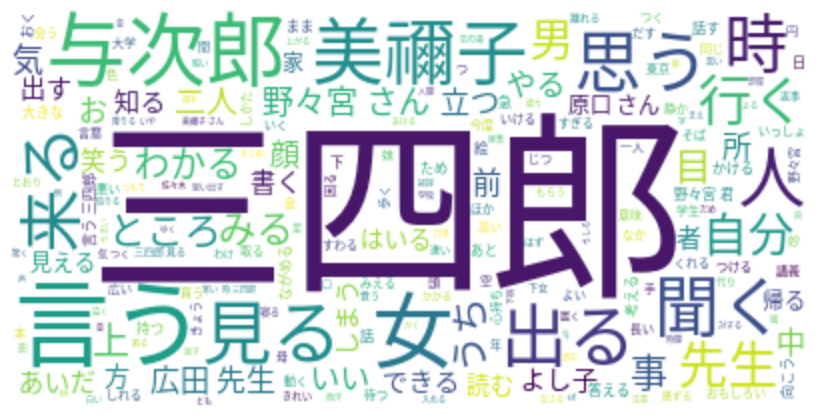

In [33]:
# ワードクラウドの表示設定と作成
wordcloud = WordCloud(
    background_color="white", max_font_size=100, font_path=fpath
).generate(' '.join(words))

# プロット
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### 共起ネットワーク

次に、共起ネットワークを作って、どの語とどの語が一緒に使われているかを調べてみましょう。

#### 共起分析

まず、共起分析を行います。文章を文に分割し、同一文中に同時に出現する単語の組を数え上げることで分析します。

In [34]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

In [35]:
def extract_words(sent, pos_tags, stopwords):
    """
    分析対象の品詞であり、不要語ではない単語を抽出する
    """
    words = [token.lemma_ for token in sent if token.pos_ in pos_tags and token.lemma_ not in stopwords]
    return words

In [106]:
def count_cooccurrence(sents, token_length="{2,}"):
    """
    同じ文中に共起する単語を行列形式で列挙する
    """
    token_pattern = f"\\b\\w{token_length}\\b"
    count_model = CountVectorizer(token_pattern=token_pattern)
    
    X = count_model.fit_transform(sents)
    words = count_model.get_feature_names_out()
    word_counts = np.asarray(X.sum(axis=0)).reshape(-1)
    
    X[X > 0] = 1 # 同じ共起が2以上出現しても1とする
    Xc = (X.T * X) # 共起行列を求めるための掛け算をする、csr形式の疎行列
    
    return words, word_counts, Xc, X

In [37]:
def find_sentence_by_cooccurrence(X, idxs):
    """
    指定された共起を含む文を見つける
    """
    occur_flags = (X[:, idxs[0]] > 0)
    for idx in idxs[1:]:
        occur_flags = occur_flags.multiply(X[:, idx] > 0)
    
    return occur_flags.nonzero()[0]

In [107]:
# 文章を解析し、共起を求める
include_pos = ("NOUN", "VERB", "ADJ", "PROPN")
stopwords = ("する", "ある", "ない", "いう", "もの", "こと", "よう", "なる", "ほう", "いる", "くる", "さん")

sents = []
with open(input_fn, "r") as f:
    for line in f:
        doc = nlp(line)
        tmp = [' '.join(extract_words(sent, include_pos, stopwords)) for sent in doc.sents]
        sents.extend(tmp)

words, word_counts, Xc, X = count_cooccurrence(sents)

In [44]:
# 共起ランキングを出力する
# 共起行列Xcは疎行列なので、非ゼロ要素のみをカウンタに格納する
counter = Counter()
for i, j in zip(*Xc.nonzero()):
    if i >= j:
        continue
    counter[(i, j)] += Xc[i, j]

# 共起の出現頻度top 20を出力する
for (i, j), c in counter.most_common(20):
    print(f"{c:>3d} ({words[i]}, {words[j]})")

120 (先生, 広田)
103 (三四郎, 見る)
 82 (三四郎, 言う)
 71 (三四郎, 美禰子)
 68 (三四郎, 思う)
 67 (三四郎, 与次郎)
 60 (三四郎, 来る)
 60 (与次郎, 言う)
 56 (三四郎, 聞く)
 56 (先生, 言う)
 50 (三四郎, 出る)
 39 (三四郎, 自分)
 38 (来る, 言う)
 34 (三四郎, 出す)
 33 (美禰子, 言う)
 33 (聞く, 言う)
 33 (言う, 野々宮)
 31 (出る, 来る)
 31 (行く, 言う)
 30 (三四郎, 答える)


In [43]:
# 指定した共起を含む文のリストを出力する
sents_orig = []
with open(input_fn, "r") as f:
    for line in f:
        doc = nlp(line)
        tmp = list(doc.sents)
        sents_orig.extend(tmp)
        
# すべての単語の通り番号を求める
words_lookup = { word: index for index, word in enumerate(words) }

In [45]:
# 共起語を指定する
lookup_words = ["野々宮", "美禰子"]

# 指定した共起語のインデックスを求める
idxs = list(map(lambda x: words_lookup[x], lookup_words))

# 指定した共起を含む文のリストを出力する
for i in find_sentence_by_cooccurrence(X, idxs):
    print(f"{i:>5d}: {sents_orig[i]}")

 3001: その影が折戸の外へ隠れると、美禰子は急に思い出したように「そうそう」と言いながら、庭先に脱いであった下駄をはいて、野々宮のあとを追いかけた。
 3237: 話は野々宮と美禰子のあいだに起こりつつある。
 3303: 歩きながら考えると、いまさき庭のうちで、野々宮と美禰子が話していた談柄が近因である。
 4395: 野々宮さんの妹といっしょに美禰子もいるだろう。
 4691: 　三四郎はその時はじめて美禰子から野々宮のおっかさんが国へ帰ったということを聞いた。
 4692: おっかさんが帰ると同時に、大久保を引き払って、野々宮さんは下宿をする、よし子は当分美禰子の家から学校へ通うことに、相談がきまったんだそうである。
 4700: 絶えず往来しているうちには野々宮さんと美禰子との関係も次第次第に移ってくる。
 4729: 美禰子の野々宮に対する賛辞のつづきは、ざっとこうである。
 4738: 自分が、野々宮に対するほどな尊敬を美禰子から受けえないのは当然である。
 4859: 美禰子のそばに野々宮さんを置くとなお苦しんでくる。
 4861: だから先生の所へ来ると、野々宮さんと美禰子との関係がおのずから明瞭になってくるだろうと思う。
 5881: 美禰子は呼ばれた原口よりは、原口より遠くの野々宮を見た。
 6634: 　三四郎は美禰子からもれて、よし子に伝わって、それが野々宮さんに知れているんだと判じた。
 8172: 野々宮さんが立つとともに、美禰子のうしろにいたよし子の姿も見えた。


#### 共起ネットワークの作成

共起分析の結果に基づいて共起ネットワークを作成します。

In [48]:
!pip install networkx pyvis japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.8 MB/s eta 0:00:000m eta 0:00:0136m0:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 592.8/592.8 kB 8.2 MB/s eta 0:00:00 MB/s eta 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 17.3 MB/s eta 0:00:00m eta 0:00:010:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyvis: filename=pyvis-0.3.0-py3-none-any.whl size=600233 sha256=290a0f8c75147d66122d6833fd788946e72e7138ab229d3269a1f4608403f8cd
  Stored in directory: /Users/shu/Library/Caches/pip/wheels/2d/0c/a1/dcfc68ca322facd602844e796269805fb0984cbd938a472c77
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=b9f5d8ace547c227eaa90ec5f64ef17d53de3a184a44288922573da584b5a534
  Stored in directory: /Users/shu/Library/Caches/pip/wheels/60/3c/f5/aa298cf26daec537a1abba748663aba6ca4a578a144ce530bd
Successfully built pyvis japanize_matplotlib

[noti

In [51]:
import networkx as nx
from pyvis.network import Network
import japanize_matplotlib

In [53]:
def word_weights(words, word_counts):
    """
    単語の最多頻度が1となるような相対値として単語の重みを求める
    """
    count_max = word_counts.max()
    weights = [(word, {"weight": count / count_max})
               for word, count in zip(words, word_counts)]
    return weights

In [54]:
def cooccurrence_weights(words, Xc, weight_cutoff):
    """
    共起の最多頻度が1となるような相対値として共起の重みを求める
    共起の重みがweight_cutoffより低い共起は除外する
    """
    Xc_max = Xc.max()
    cutoff = weight_cutoff * Xc_max
    weights = [(words[i], words[j], Xc[i, j] / Xc_max)
               for i, j in zip(*Xc.nonzero()) if i < j and Xc[i, j] > cutoff]
    return weights

In [55]:
def create_network(words, word_counts, Xc, weight_cutoff):
    """
    語、単語頻度、共起行列から共起ネットワークをNetworkX形式で得る
    """
    G = nx.Graph()
    
    weights_w = word_weights(words, word_counts)
    G.add_nodes_from(weights_w)
    
    weights_c = cooccurrence_weights(words, Xc, weight_cutoff)
    G.add_weighted_edges_from(weights_c)
    
    G.remove_nodes_from(list(nx.isolates(G)))
    return G

In [113]:
def pyplot_network(G):
    """
    NetworkX形式で与えられた共起ネットワークをpyplotで描画する
    """
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G, k=0.1)
    
    weights_n = np.array(list(nx.get_node_attributes(G, "weight").values()))
    nx.draw_networkx_nodes(G, pos, node_size=300 * weights_n)
    weights_e = np.array(list(nx.get_edge_attributes(G, "weight").values()))
    nx.draw_networkx_edges(G, pos, width=20 * weights_e)
    
    nx.draw_networkx_labels(G, pos, font_family="IPAexGothic")
    
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [121]:
def nx2pyvis_G(G):
    """
    NetworkX形式で与えられた共起ネットワークをpyvisで描画する
    """
    pyvis_G = Network(width="800px", height="800px", notebook=True)
    for node, attrs in G.nodes(data=True):
        pyvis_G.add_node(node, title=node, size=30 * attrs["weight"])
    for node1, node2, attrs in G.edges(data=True):
        pyvis_G.add_edge(node1, node2, width=20 * attrs["weight"])
    
    return pyvis_G

In [116]:
# ネットワークを作る
G = create_network(words, word_counts, Xc, 0.01)

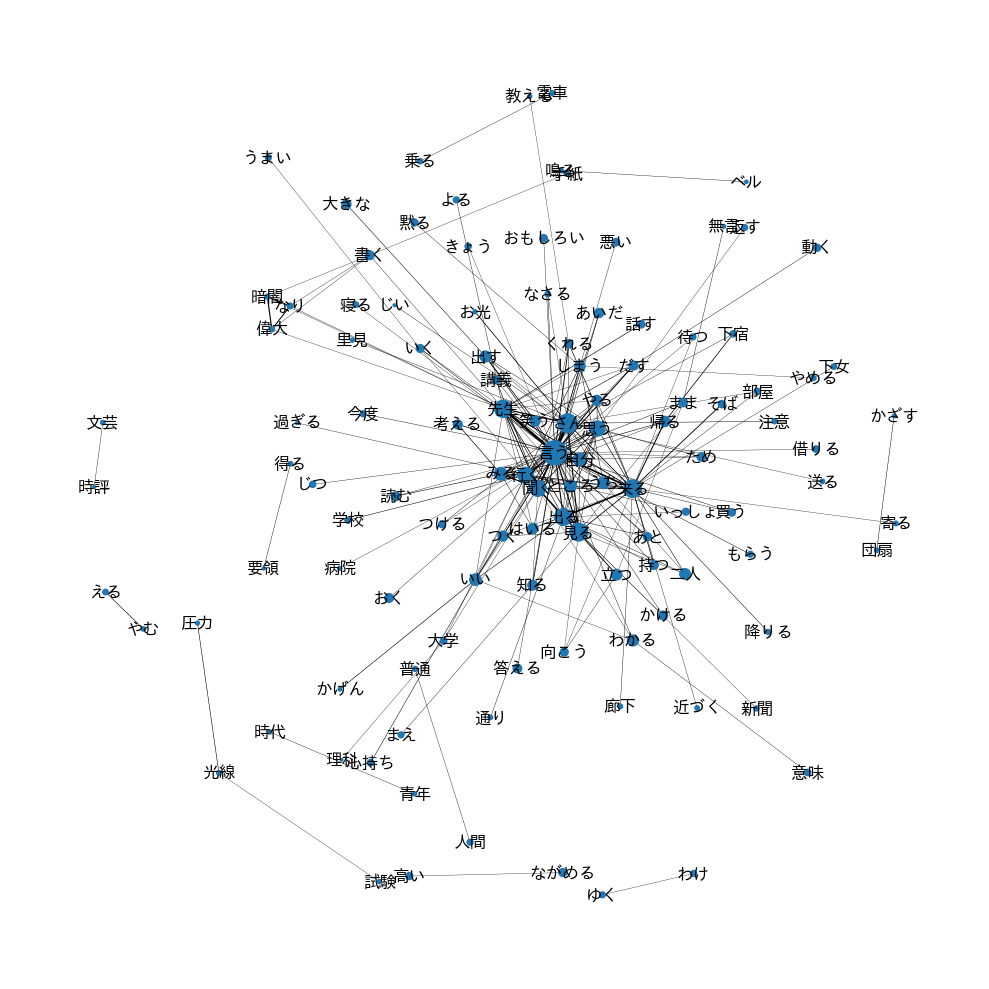

In [117]:
# 静的ビジュアライゼーション
pyplot_network(G)

In [123]:
# インタラクティブなビジュアライゼーション
pyvis_G = nx2pyvis_G(G)
pyvis_G.show("network.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


### 共起ヒートマップ

共起関係をネットワークではなく、ヒートマップとして表現することもできます。

登場人物の共起ヒートマップを作ってみましょう。

#### データフレームを作る

In [209]:
# 文章を解析し、共起を求める
include_pos = ("NOUN", "PROPN")
stopwords = ("する", "ある", "ない", "いう", "もの", "こと", "よう", "なる", "ほう", "いる", "くる", "さん")

sents = []
with open(input_fn, "r") as f:
    for line in f:
        doc = nlp(line)
        tmp = [' '.join(extract_words(sent, include_pos, stopwords)) for sent in doc.sents]
        sents.extend(tmp)

words, word_counts, Xc, X = count_cooccurrence(sents)

In [224]:
# 共起行列Xcは疎行列なので、非ゼロ要素のみをカウンタに格納する
counter = Counter()
for i, j in zip(*Xc.nonzero()):
    if i >= j:
        continue
    counter[(i, j)] += Xc[i, j]

# 共起の出現頻度top 20を出力する
for (i, j), c in counter.most_common(20):
    print(f"{c:>3d} ({words[i]}, {words[j]})")

120 (先生, 広田)
 71 (三四郎, 美禰子)
 67 (三四郎, 与次郎)
 39 (三四郎, 自分)
 28 (まま, 三四郎)
 26 (三四郎, 先生)
 23 (三四郎, 広田)
 23 (三四郎, 野々宮)
 22 (うち, 三四郎)
 22 (与次郎, 先生)
 21 (あと, 三四郎)
 20 (あいだ, 三四郎)
 20 (三四郎, 二人)
 18 (そば, 三四郎)
 18 (ところ, 三四郎)
 16 (与次郎, 広田)
 16 (先生, 野々宮)
 15 (よし子, 三四郎)
 15 (よし子, 美禰子)
 15 (三四郎, 意味)


In [232]:
# 行名を用意する

columns = set(Xc.nonzero()[0])
columns_text = [words[i] for i in columns]

In [233]:
# すべて0のデータフレームを用意する

import pandas as pd

df = pd.DataFrame(np.zeros((len(columns), len(columns))), index=columns_text, columns=columns_text)

In [234]:
# データフレームに頻度を入れる

for cord, count in counter.items():
    df.iloc[cord] = count

In [235]:
# 登場人物名のみを取り出す

characters = ["三四郎", "広田", "野々宮", "佐々木", "与次郎", "美禰子", "先生", "原口", "里見"]
df_characters = df[characters].filter(items=characters, axis=0)

#### 共起ヒートマップの作成

In [236]:
import plotly.express as px

fig = px.imshow(df_characters, color_continuous_scale=px.colors.sequential.Oranges)
fig.show()

人々のインタラクションの多寡が示されました。